# Proposta Analítica da JLG Data Analytics

In [192]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [210]:
# paths

closed_deals = "../dataset/marketing_funnel/olist_closed_deals_dataset.csv"
orders = "../dataset/eccomerce/olist_orders_dataset.csv"
mql = "../dataset/marketing_funnel/olist_marketing_qualified_leads_dataset.csv"
products = "../dataset/eccomerce/olist_products_dataset.csv"
order_itens = "../dataset/eccomerce/olist_order_items_dataset.csv"
customer = "../dataset/eccomerce/olist_customers_dataset.csv"
seller = "../dataset/eccomerce/olist_sellers_dataset.csv"
payments = "../dataset/eccomerce/olist_order_payments_dataset.csv"

In [194]:
# variáveis

df_pedidos = pd.read_csv(orders)
df_negocio_fechado = pd.read_csv(closed_deals)
df_leads_qualificados = pd.read_csv(mql)
df_produtos = pd.read_csv(products)
df_itens_pedidos = pd.read_csv(order_itens)
df_clientes = pd.read_csv(customer)
df_vendedores = pd.read_csv(seller)
df_pagamentos = pd.read_csv(payments)



### Funil de Marketing & Geração de Leads

Qual a taxa de conversão de leads qualificados (MQLs) em vendas fechadas?

In [195]:


total_conversoes = df_negocio_fechado['mql_id'].count()
total_leads_qualificados = df_leads_qualificados['mql_id'].count()

taxa_de_conversao = (total_conversoes / total_leads_qualificados) * 100

print(f'A taxa de conversão de leads é {taxa_de_conversao:.2f} %')

A taxa de conversão de leads é 10.53 %


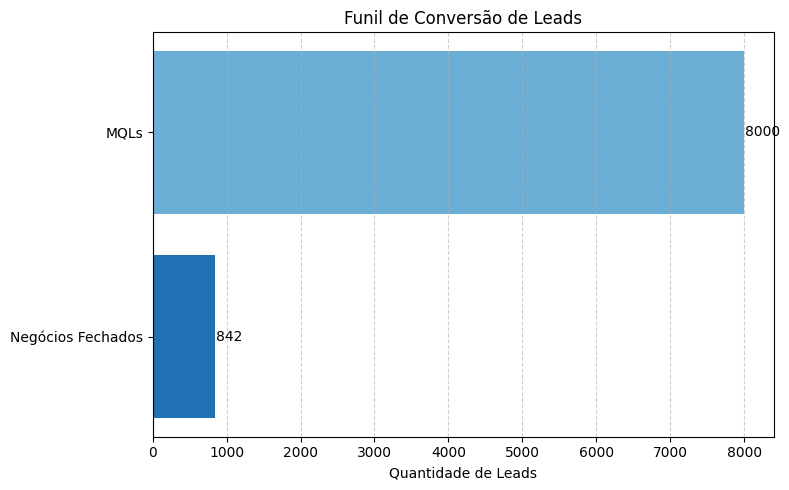

In [196]:
# funil

total_leads_qualificados = df_leads_qualificados['mql_id'].nunique()
total_conversoes = df_negocio_fechado['mql_id'].nunique()

etapas = ['MQLs', 'Negócios Fechados']
valores = [total_leads_qualificados, total_conversoes]

plt.figure(figsize=(8,5))
plt.barh(etapas, valores, color=['#6baed6', '#2171b5'])
plt.title('Funil de Conversão de Leads')
plt.xlabel('Quantidade de Leads')
for i, v in enumerate(valores):
    plt.text(v + 10, i, str(v), va='center')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Quais origens de leads (social, paid_search etc.) geram mais conversões?

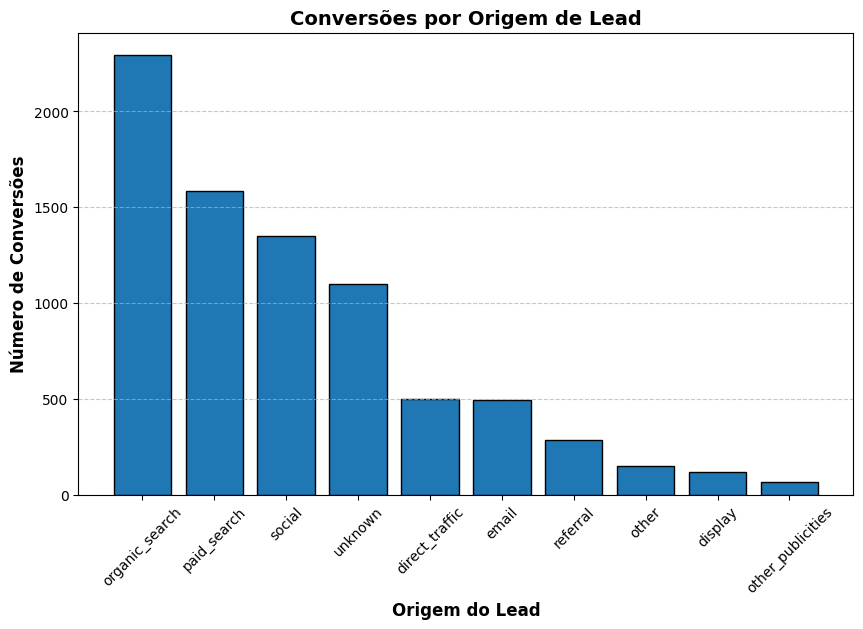

In [197]:

df_merged = df_leads_qualificados.merge(df_negocio_fechado[['mql_id', 'lead_behaviour_profile', 'won_date']], on="mql_id", how="left")


#imagem
if 'origin' in df_merged.columns:
    conversions_by_origin = df_merged['origin'].value_counts().reset_index()
    conversions_by_origin.columns = ['origin', 'conversions']
    plt.figure(figsize=(10, 6))
    plt.bar(conversions_by_origin['origin'], conversions_by_origin['conversions'], color='#1f77b4', edgecolor='black')
    plt.xlabel('Origem do Lead', fontsize=12, fontweight='bold')
    plt.ylabel('Número de Conversões', fontsize=12, fontweight='bold')
    plt.title('Conversões por Origem de Lead', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("A coluna 'origin' não foi encontrada no dataframe!")

Qual o tempo médio entre o primeiro contato e o fechamento de negócio?

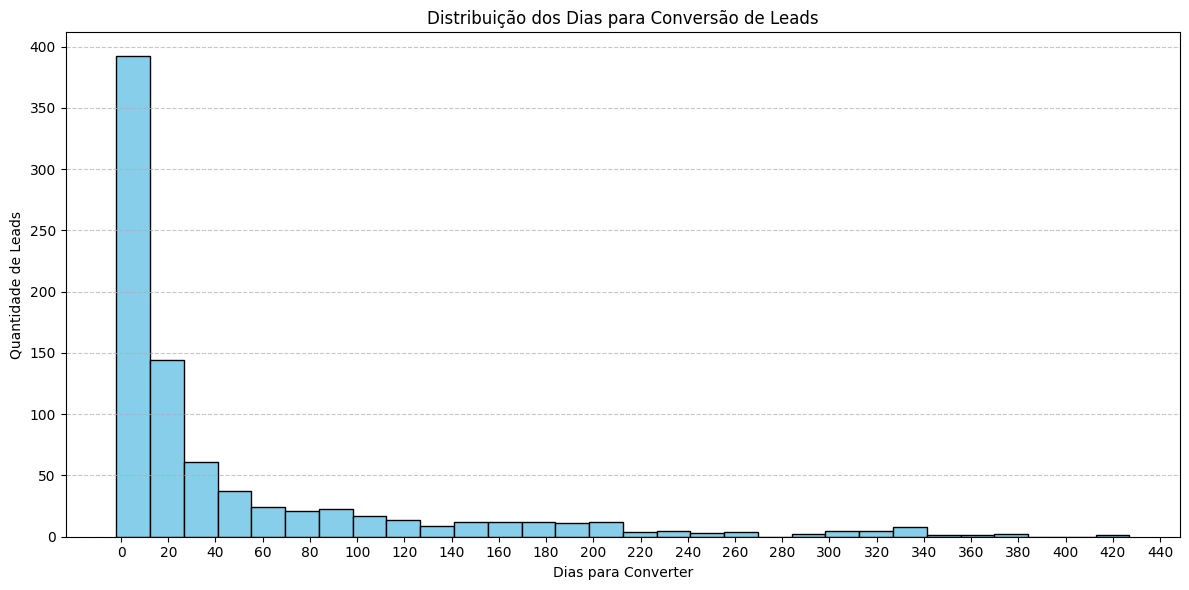

In [198]:
# Tempo de conversão

df_leads = pd.merge(
    df_leads_qualificados,
    df_negocio_fechado[['mql_id', 'won_date', ]],
    on='mql_id',
    how='left',
    indicator=True
)
df_leads['converted'] = df_leads['_merge'] == 'both'

df_leads['first_contact_date'] = pd.to_datetime(df_leads['first_contact_date'])
df_leads['won_date'] = pd.to_datetime(df_leads['won_date'])

df_leads['days_to_convert'] = (df_leads['won_date'] - df_leads['first_contact_date']).dt.days


# gráfico

plt.figure(figsize=(12,6))
plt.hist(df_leads[df_leads['converted']]['days_to_convert'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Dias para Conversão de Leads')
plt.xlabel('Dias para Converter')
plt.ylabel('Quantidade de Leads')
plt.xticks(range(0, 450, 20))  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Quais perfis comportamentais (eagle, cat...) têm maior taxa de fechamento?

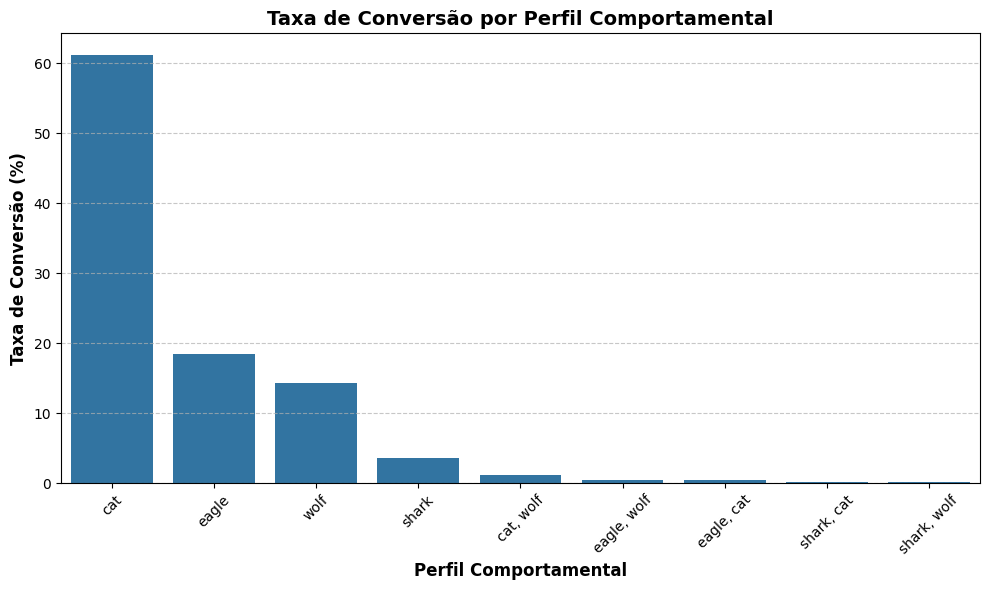

In [199]:
df_merged = pd.merge(
    df_leads_qualificados,
    df_negocio_fechado[['mql_id', 'lead_behaviour_profile']],
    on='mql_id',
    how='inner' 
)
conversion_rate = (
    df_merged['lead_behaviour_profile']
    .value_counts(normalize=True)
    .mul(100)
    .rename('conversion_rate')
    .reset_index()
    .rename(columns={'index': 'lead_behaviour_profile'})
)

#imagem
plt.figure(figsize=(10, 6))
sns.barplot(data=conversion_rate,x='lead_behaviour_profile',y='conversion_rate',color='#1f77b4',order=conversion_rate.sort_values('conversion_rate', ascending=False)['lead_behaviour_profile'])
plt.title('Taxa de Conversão por Perfil Comportamental', fontsize=14, fontweight='bold')
plt.xlabel('Perfil Comportamental', fontsize=12, fontweight='bold')
plt.ylabel('Taxa de Conversão (%)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Qual segmento de negócio (ex: pet, car_accessories) tem maior sucesso no funil?

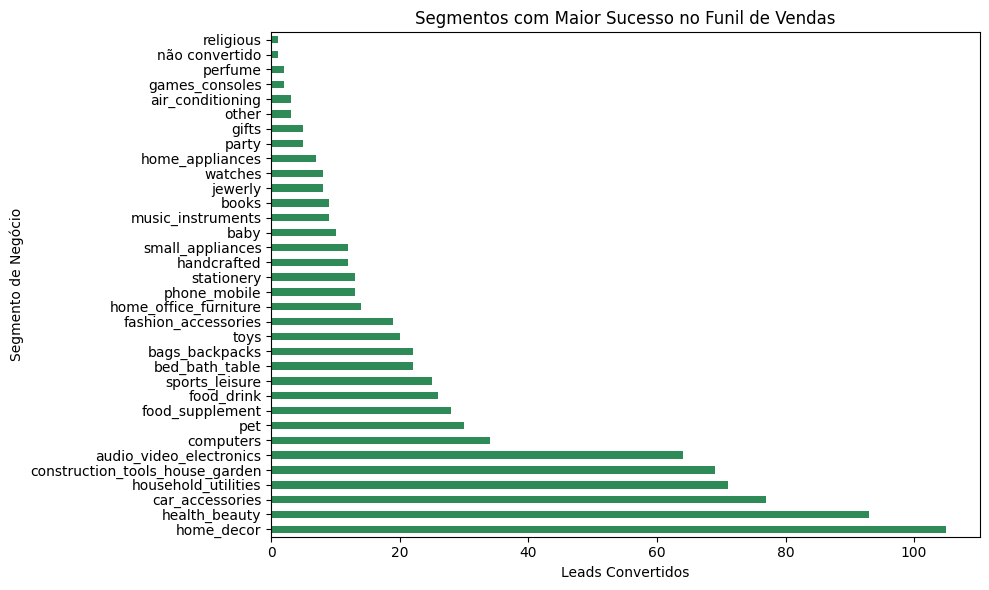

In [200]:
df_leads = pd.merge(
    df_leads_qualificados,
    df_negocio_fechado[['mql_id', 'won_date', 'business_segment']],
    on='mql_id',
    how='left',
    indicator=True
)
df_leads['converted'] = df_leads['_merge'] == 'both'

df_leads['business_segment'] = df_leads['business_segment'].fillna('não convertido')

contagem_segmentos = df_leads['business_segment'].value_counts()
agrupados = df_leads.groupby('business_segment')['converted'].value_counts().unstack().fillna(0)

conversoes_por_segmento = df_leads[df_leads['converted']]['business_segment'].value_counts()

# Gráfico
conversoes_por_segmento.plot(kind='barh', figsize=(10,6), color='seagreen')
plt.title('Segmentos com Maior Sucesso no Funil de Vendas')
plt.xlabel('Leads Convertidos')
plt.ylabel('Segmento de Negócio')
plt.tight_layout()
plt.show()





### Pedidos, Vendas & Produtos

Qual o ticket médio por pedido?

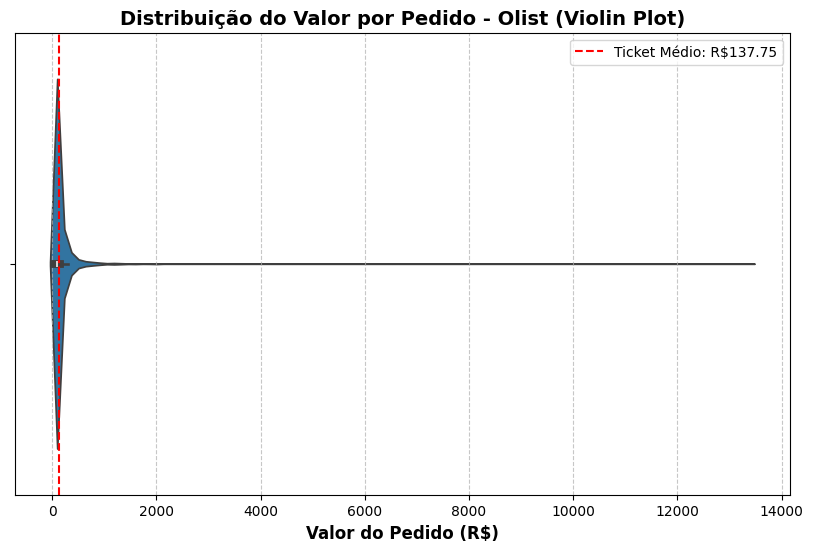

In [201]:
order_totals = df_itens_pedidos.groupby('order_id')['price'].sum().reset_index()
ticket_medio = order_totals['price'].mean()

#imagem
plt.figure(figsize=(10, 6))
sns.violinplot(x=order_totals['price'], color='#1f77b4')
plt.axvline(ticket_medio, color='red', linestyle='--', label=f'Ticket Médio: R${ticket_medio:.2f}')
plt.xlabel('Valor do Pedido (R$)', fontsize=12, fontweight='bold')
plt.title('Distribuição do Valor por Pedido - Olist (Violin Plot)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Quais são as categorias de produtos mais vendidos?

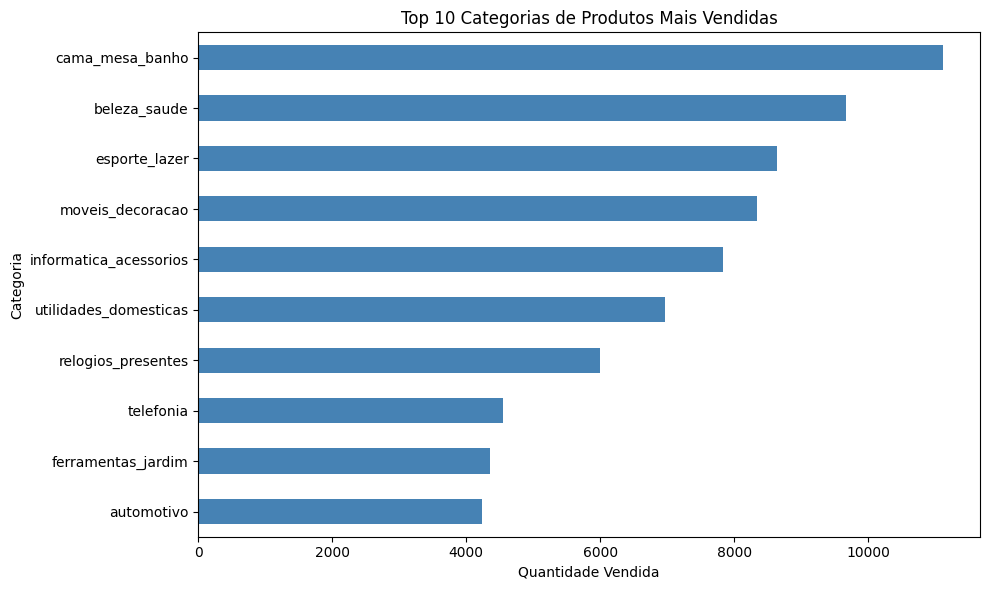

In [202]:

produtos_com_categorias = pd.merge(df_itens_pedidos, df_produtos[['product_id', 'product_category_name']], on='product_id', how='left')

produtos_mais_vendidos = produtos_com_categorias['product_category_name'].value_counts().head(10)

# Gráfico
produtos_mais_vendidos.plot(kind='barh', figsize=(10,6), color='steelblue')
plt.title('Top 10 Categorias de Produtos Mais Vendidas')
plt.xlabel('Quantidade Vendida')
plt.ylabel('Categoria')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [203]:
# Contar os produtos mais vendidos (por ID)
mais_vendidos = produtos_com_categorias['product_id'].value_counts().head(10).reset_index()
mais_vendidos.columns = ['product_id', 'quantidade_vendida']


mais_vendidos = pd.merge(mais_vendidos, df_produtos[['product_id', 'product_category_name']], on='product_id', how='left')

print(mais_vendidos)


                         product_id  quantidade_vendida  \
0  aca2eb7d00ea1a7b8ebd4e68314663af                 527   
1  99a4788cb24856965c36a24e339b6058                 488   
2  422879e10f46682990de24d770e7f83d                 484   
3  389d119b48cf3043d311335e499d9c6b                 392   
4  368c6c730842d78016ad823897a372db                 388   
5  53759a2ecddad2bb87a079a1f1519f73                 373   
6  d1c427060a0f73f6b889a5c7c61f2ac4                 343   
7  53b36df67ebb7c41585e8d54d6772e08                 323   
8  154e7e31ebfa092203795c972e5804a6                 281   
9  3dd2a17168ec895c781a9191c1e95ad7                 274   

    product_category_name  
0        moveis_decoracao  
1         cama_mesa_banho  
2      ferramentas_jardim  
3      ferramentas_jardim  
4      ferramentas_jardim  
5      ferramentas_jardim  
6  informatica_acessorios  
7      relogios_presentes  
8            beleza_saude  
9  informatica_acessorios  


Quais formas de pagamento são mais utilizadas?

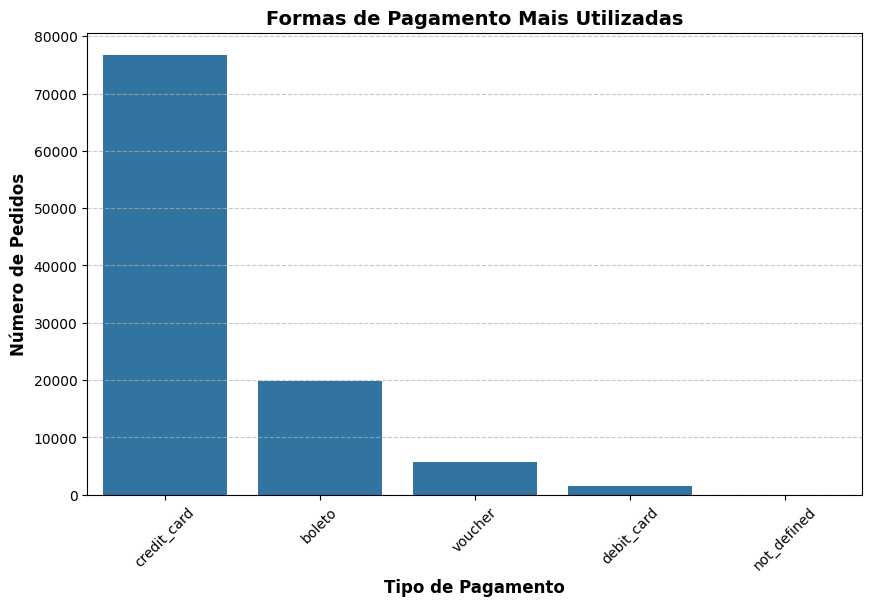

In [204]:
payment_counts = df_pagamentos['payment_type'].value_counts()

#imagem
plt.figure(figsize=(10, 6))
sns.barplot(x=payment_counts.index, y=payment_counts.values, color='#1f77b4')
plt.title('Formas de Pagamento Mais Utilizadas', fontsize=14, fontweight='bold')
plt.xlabel('Tipo de Pagamento', fontsize=12, fontweight='bold')
plt.ylabel('Número de Pedidos', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Qual o valor médio do frete por região ou por categoria?

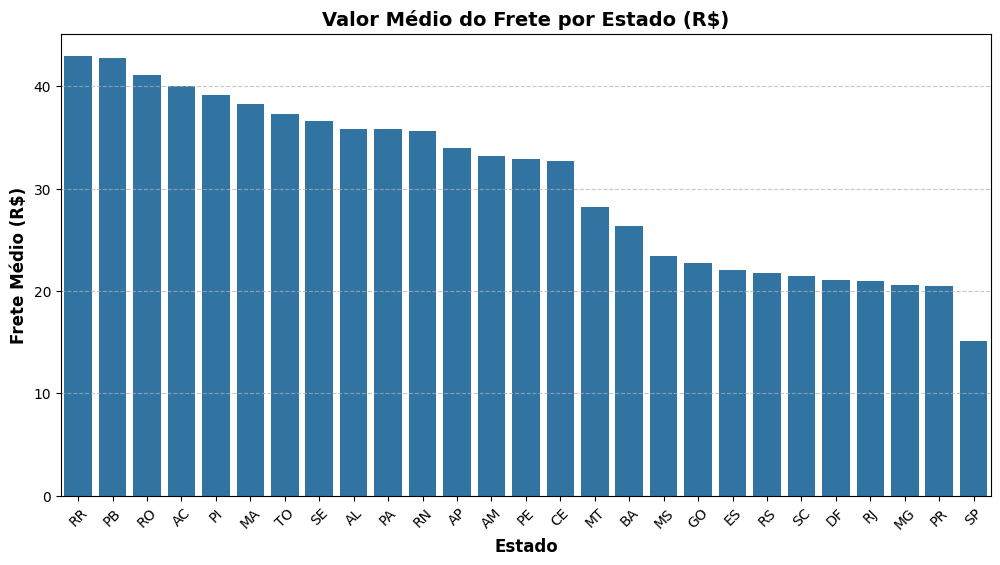

In [205]:
products = pd.read_csv('../dataset/eccomerce/olist_products_dataset.csv') 
customers = pd.read_csv('../dataset/eccomerce/olist_customers_dataset.csv')
df = df_itens_pedidos.merge(df_produtos, on='product_id', how='left') \
               .merge(df_pedidos, on='order_id', how='left') \
               .merge(df_clientes, on='customer_id', how='left')
df = df[['order_id', 'product_category_name', 'freight_value', 'customer_state']]
frete_por_estado = df.groupby('customer_state')['freight_value'].mean().sort_values(ascending=False)

#imagem
plt.figure(figsize=(12, 6))
sns.barplot(x=frete_por_estado.index, y=frete_por_estado.values, color='#1f77b4')
plt.title('Valor Médio do Frete por Estado (R$)', fontsize=14, fontweight='bold')
plt.xlabel('Estado', fontsize=12, fontweight='bold')
plt.ylabel('Frete Médio (R$)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Qual o tempo médio de entrega dos pedidos?

In [206]:


df_pedidos['order_purchase_timestamp'] = pd.to_datetime(df_pedidos['order_purchase_timestamp'])
df_pedidos['order_delivered_customer_date'] = pd.to_datetime(df_pedidos['order_delivered_customer_date'])

df_pedidos['days_to_deliver'] = (df_pedidos['order_delivered_customer_date'] - df_pedidos['order_purchase_timestamp']).dt.days

entregues = df_pedidos[df_pedidos['order_delivered_customer_date'].notnull()]


tempo_medio_entrega = df_pedidos['days_to_deliver'].mean()
print(f"Tempo médio de entrega: {tempo_medio_entrega:.2f} dias")





Tempo médio de entrega: 12.09 dias


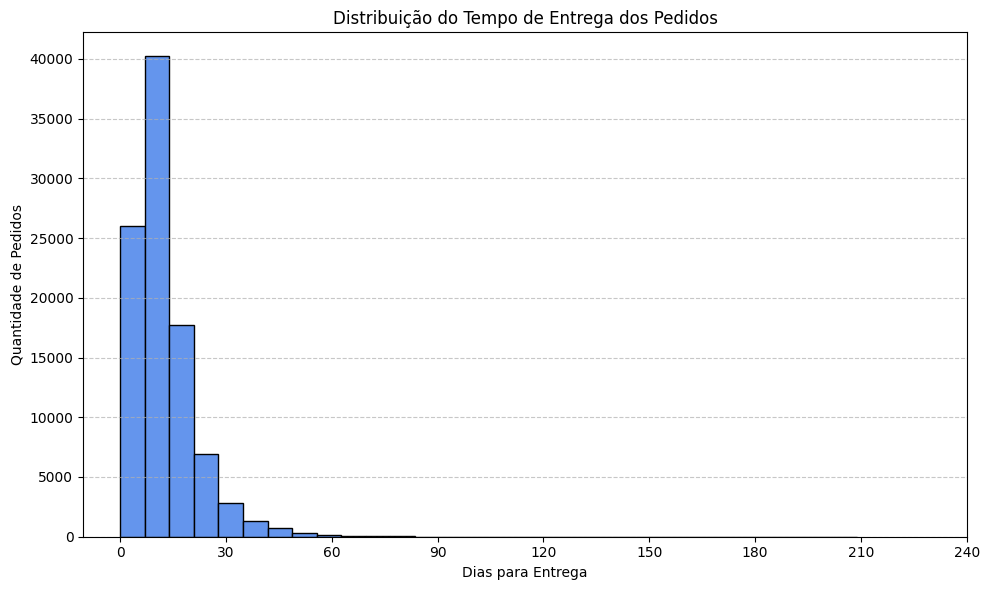

In [207]:
# Gráfico
plt.figure(figsize=(10,6))
plt.hist(entregues['days_to_deliver'], bins=30, color='cornflowerblue', edgecolor='black')
plt.title('Distribuição do Tempo de Entrega dos Pedidos')
plt.xlabel('Dias para Entrega')
plt.ylabel('Quantidade de Pedidos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 250, 30))
plt.tight_layout()
plt.show()

Qual a proporção de pedidos não entregues?

In [208]:
nao_entregue_status = ['canceled', 'unavailable', 'created', 'approved', 'processing']
status_traduzidos = {
    'canceled': 'Cancelado',
    'unavailable': 'Indisponível',
    'created': 'Criado',
    'approved': 'Aprovado',
    'processing': 'Processando',
    'shipped': 'Enviado',
    'delivered': 'Entregue',
    'invoiced': 'Faturado'
}
total_pedidos = len(df_pedidos)
pedidos_nao_entregues = df_pedidos[df_pedidos['order_status'].isin(status_traduzidos)]
total_nao_entregues = len(pedidos_nao_entregues)

proporcao = (total_nao_entregues / total_pedidos) * 100

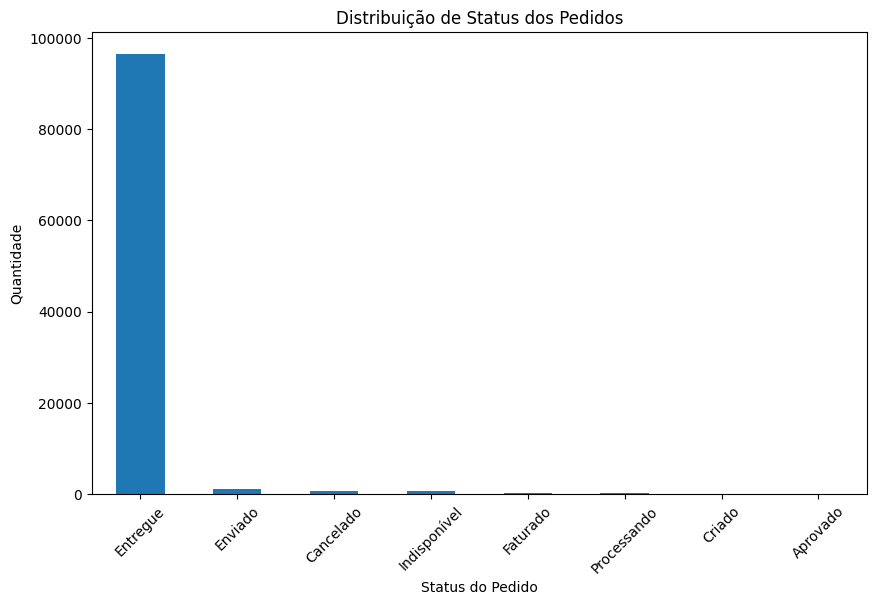

In [211]:
status_counts = df_pedidos['order_status'].value_counts()
status_counts_traduzido = status_counts.rename(index=status_traduzidos)

# Gráfico de barras
plt.figure(figsize=(10, 6))
status_counts_traduzido.plot(kind='bar', color='#1f77b4')
plt.title('Distribuição de Status dos Pedidos')
plt.xlabel('Status do Pedido')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.show()

Como os pedidos variam ao longo do tempo?

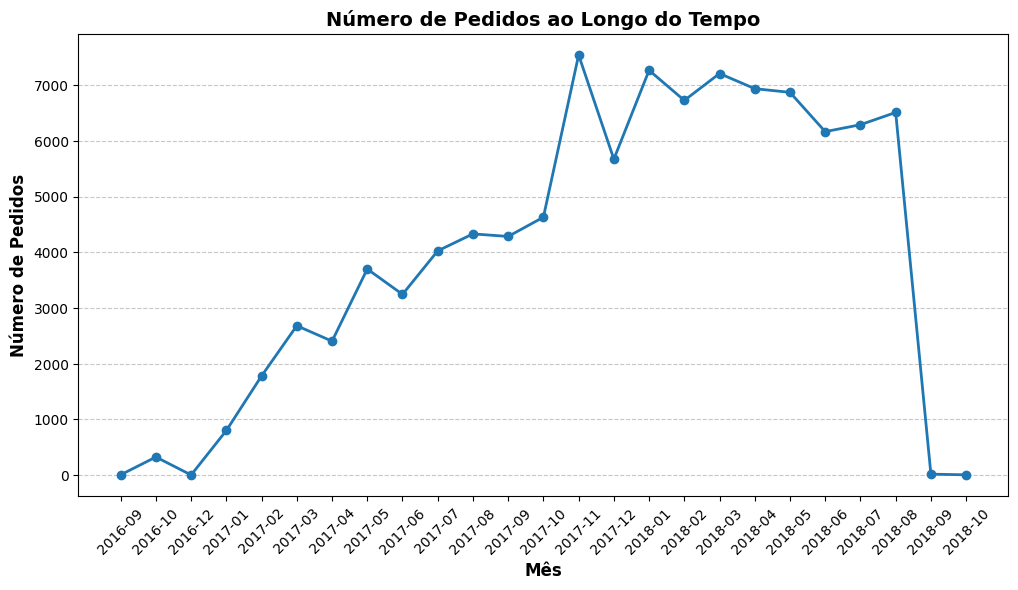

In [ ]:
df_pedidos['order_purchase_timestamp'] = pd.to_datetime(df_pedidos['order_purchase_timestamp'])
df_pedidos['order_month'] = df_pedidos['order_purchase_timestamp'].dt.to_period('M')
orders_by_month = df_pedidos['order_month'].value_counts().sort_index()

#imagem
plt.figure(figsize=(12, 6))
plt.plot(orders_by_month.index.astype(str), orders_by_month.values, marker='o', linestyle='-', color='#1f77b4', linewidth=2)
plt.title('Número de Pedidos ao Longo do Tempo', fontsize=14, fontweight='bold')
plt.xlabel('Mês', fontsize=12, fontweight='bold')
plt.ylabel('Número de Pedidos', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Clientes & Comportamento

Qual a distribuição de clientes por estado e cidade?

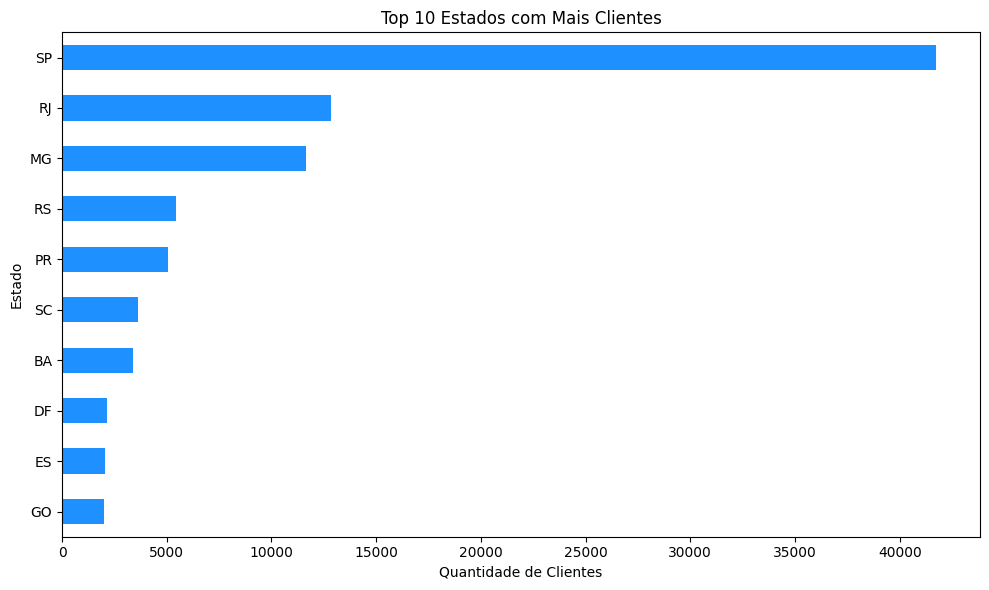

In [ ]:
clientes_por_estado = df_clientes['customer_state'].value_counts().sort_values(ascending=False)
clientes_por_cidade = df_clientes['customer_city'].value_counts().sort_values(ascending=False)

# Por estados

clientes_por_estado.head(10).plot(kind='barh', figsize=(10,6), color='dodgerblue')
plt.title('Top 10 Estados com Mais Clientes')
plt.xlabel('Quantidade de Clientes')
plt.ylabel('Estado')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




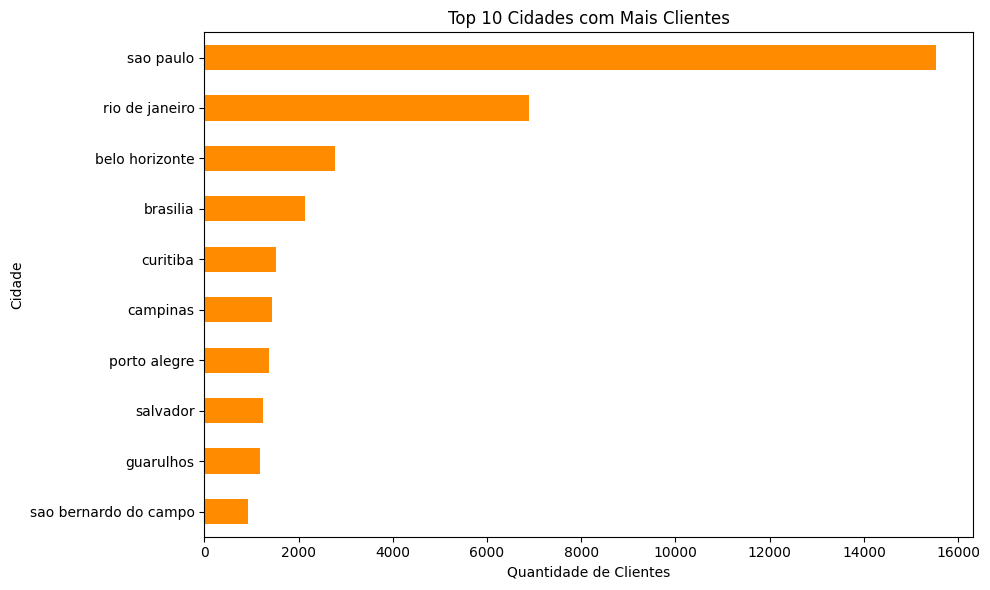

In [ ]:
# Por cidades

clientes_por_cidade.head(10).plot(kind='barh', figsize=(10,6), color='darkorange')
plt.title('Top 10 Cidades com Mais Clientes')
plt.xlabel('Quantidade de Clientes')
plt.ylabel('Cidade')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Qual a proporção de clientes recorrentes vs. novos?

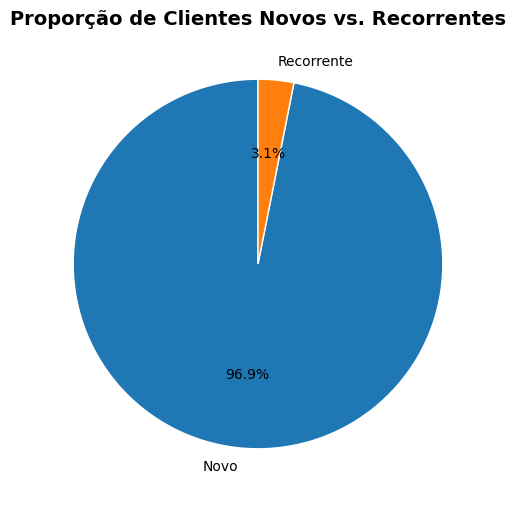

In [ ]:
df_clientes
orders_merged = df_pedidos.merge(df_clientes, on='customer_id', how='left')
customer_counts = orders_merged['customer_unique_id'].value_counts()
new_customers = (customer_counts == 1).sum()
recurring_customers = (customer_counts > 1).sum()
customer_types = pd.DataFrame({"Tipo de Cliente": ["Novo", "Recorrente"],"Quantidade": [new_customers, recurring_customers]})

#imagem
plt.figure(figsize=(6, 6))
plt.pie(customer_types["Quantidade"], labels=customer_types["Tipo de Cliente"], autopct='%1.1f%%', startangle=90, colors=["#1f77b4", "#ff7f0e"],wedgeprops={'edgecolor': 'white'})
plt.title("Proporção de Clientes Novos vs. Recorrentes", fontsize=14, fontweight='bold')
plt.show()

Qual o perfil geográfico dos clientes com maior volume de compras?

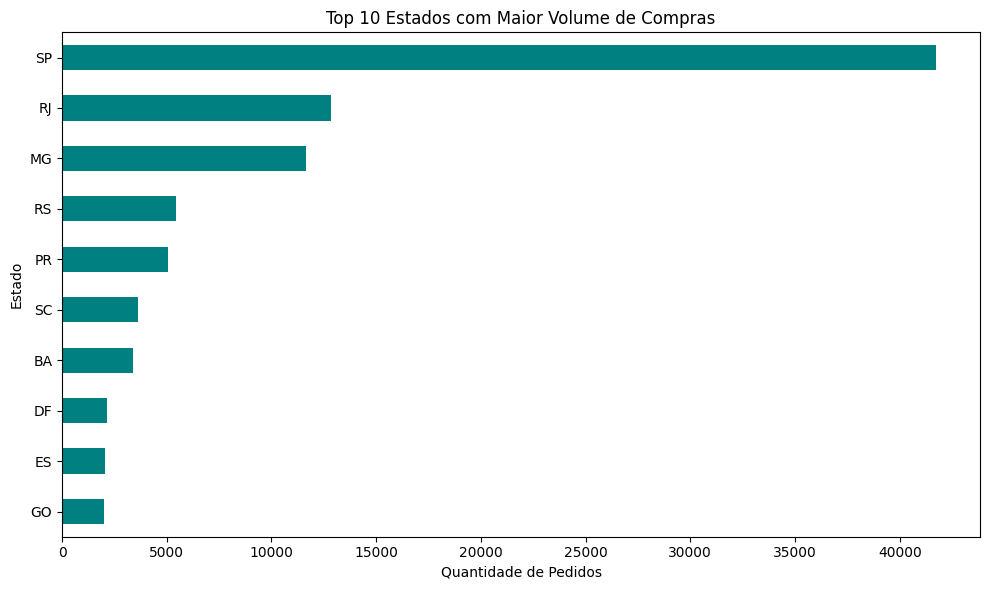

In [ ]:


pedidos_por_local = pd.merge(
    df_pedidos[['order_id', 'customer_id']],
    df_clientes[['customer_id', 'customer_city', 'customer_state']],
    on='customer_id',
    how='left'
)

pedidos_por_estado = pedidos_por_local['customer_state'].value_counts().sort_values(ascending=False)

pedidos_por_estado.head(10).plot(kind='barh', figsize=(10,6), color='teal')
plt.title('Top 10 Estados com Maior Volume de Compras')
plt.xlabel('Quantidade de Pedidos')
plt.ylabel('Estado')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




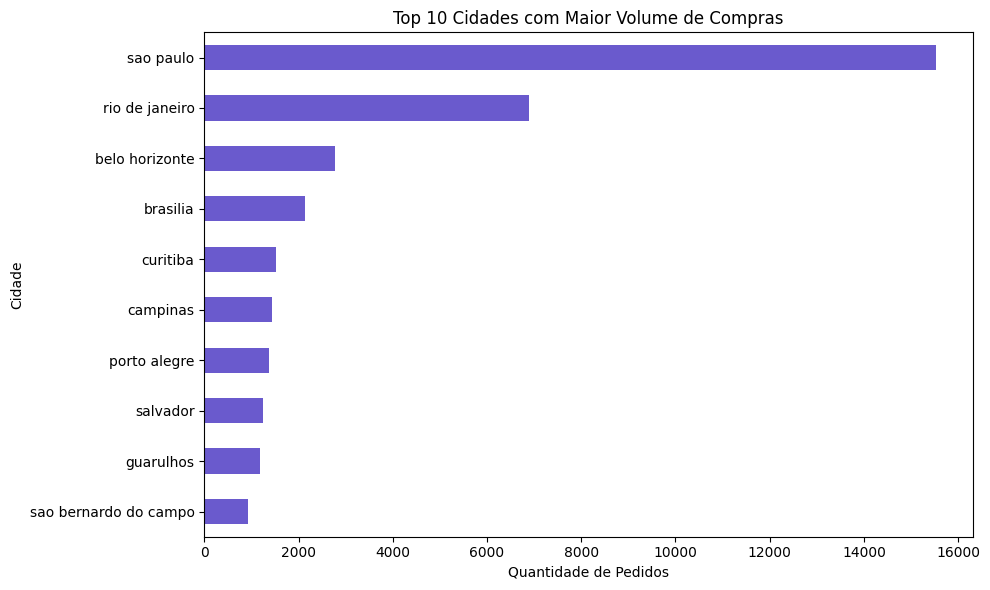

In [ ]:
# Por cidade

pedidos_por_cidade = pedidos_por_local['customer_city'].value_counts().sort_values(ascending=False)

pedidos_por_cidade.head(10).plot(kind='barh', figsize=(10,6), color='slateblue')
plt.title('Top 10 Cidades com Maior Volume de Compras')
plt.xlabel('Quantidade de Pedidos')
plt.ylabel('Cidade')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



Quais são os hábitos de compra dos clientes?

In [ ]:
if 'customer_unique_id' in df_pedidos.columns:
    pedidos = df_pedidos.drop(columns=['customer_unique_id'])

freq_por_cliente = pedidos['customer_unique_id'].value_counts()
clientes_recompra = freq_por_cliente[freq_por_cliente > 1].count()

taxa_recompra = (clientes_recompra / freq_por_cliente.count()) * 100

print(f"Clientes com recompra: {clientes_recompra}")
print(f"A taxa de recompra entre os clientes é de aproximadamente {taxa_recompra:.2f} %")



Clientes com recompra: 2997
A taxa de recompra entre os clientes é de aproximadamente 3.12 %


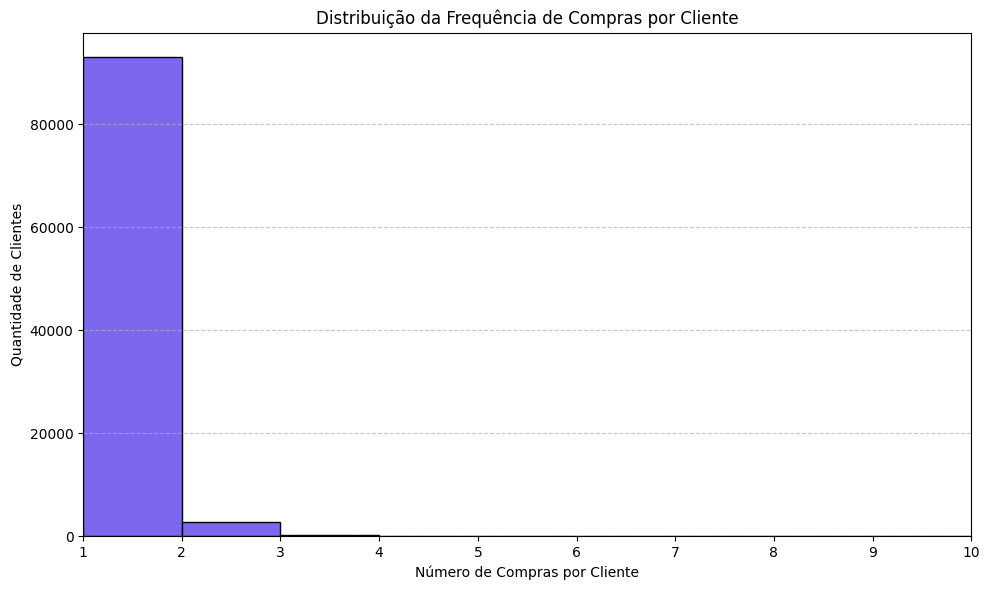

In [ ]:
# Gráfico

plt.figure(figsize=(10,6))
plt.hist(freq_por_cliente, bins=range(1, freq_por_cliente.max()+1), color='mediumslateblue', edgecolor='black')
plt.title('Distribuição da Frequência de Compras por Cliente')
plt.xlabel('Número de Compras por Cliente')
plt.ylabel('Quantidade de Clientes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(1, 10)
plt.tight_layout()
plt.show()


### Sellers & Logística

Quais vendedores geram mais vendas ou receita?

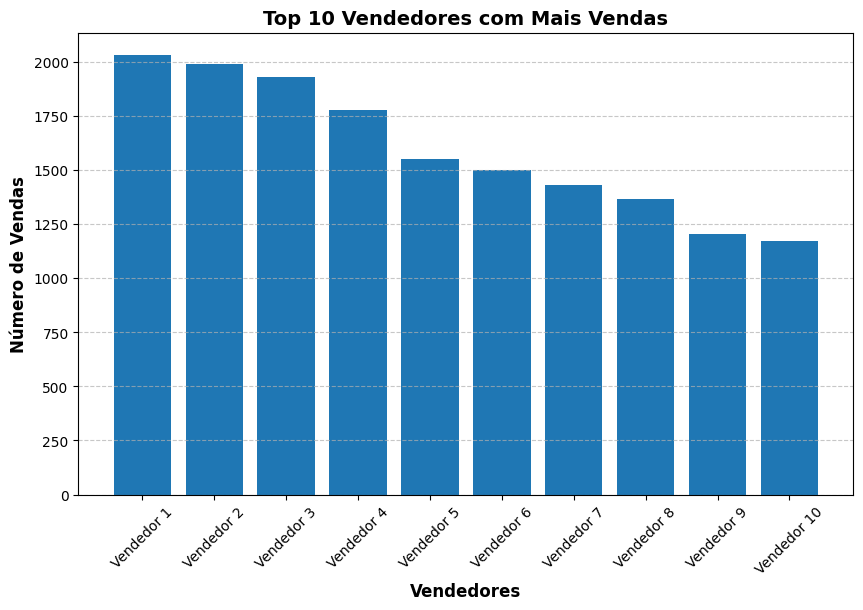

In [ ]:
seller_sales = df_itens_pedidos['seller_id'].value_counts().reset_index()
seller_sales.columns = ['seller_id', 'num_vendas']
top_sellers = seller_sales.head(10).copy()  
top_sellers['vendedor_nome'] = ['Vendedor ' + str(i+1) for i in range(len(top_sellers))]

#imagem
plt.figure(figsize=(10, 6))
plt.bar(top_sellers['vendedor_nome'], top_sellers['num_vendas'], color='#1f77b4')
plt.xlabel('Vendedores', fontsize=12, fontweight='bold')
plt.ylabel('Número de Vendas', fontsize=12, fontweight='bold')
plt.title('Top 10 Vendedores com Mais Vendas', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Quais estados concentram mais vendedores ativos e vendas?

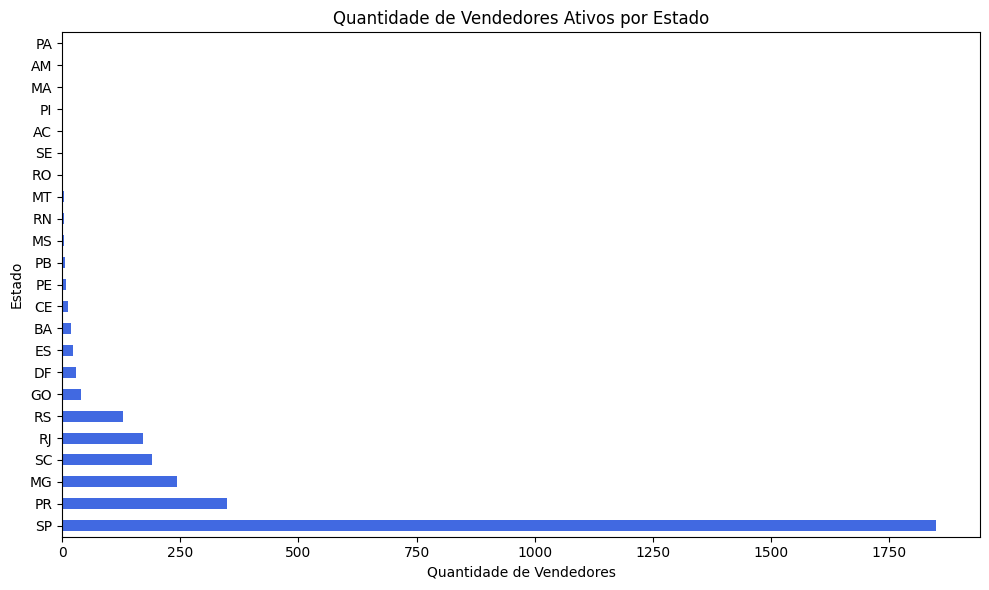

In [ ]:
vendedores_por_estado = df_vendedores['seller_state'].value_counts()

vendedores_por_estado.plot(kind='barh', figsize=(10,6), color='royalblue')
plt.title('Quantidade de Vendedores Ativos por Estado')
plt.xlabel('Quantidade de Vendedores')
plt.ylabel('Estado')
plt.tight_layout()
plt.show()


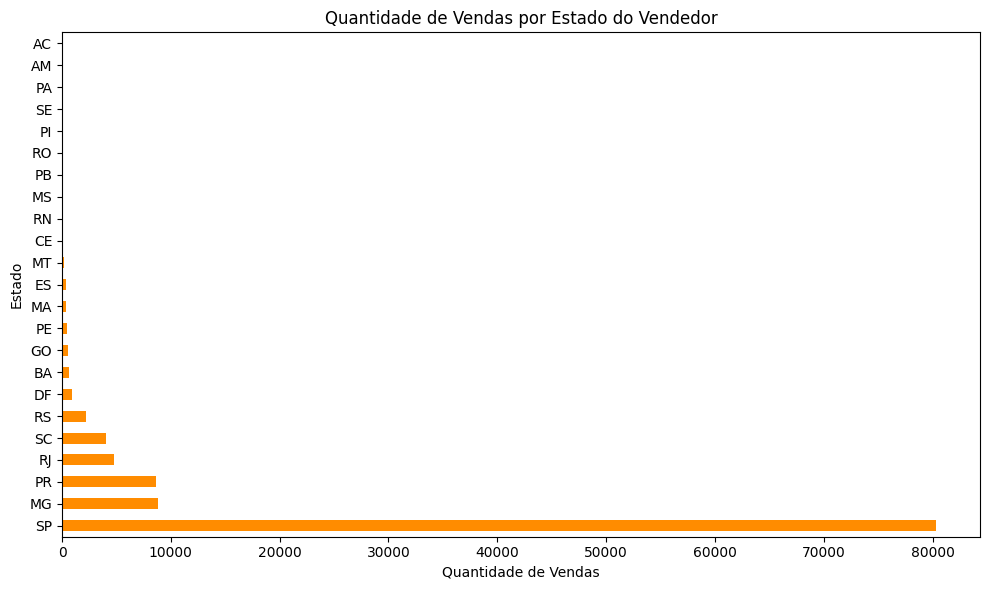

In [ ]:
# vendas por estados

vendas_com_estado = pd.merge(df_itens_pedidos, df_vendedores[['seller_id', 'seller_state']], on='seller_id', how='left')

vendas_por_estado = vendas_com_estado['seller_state'].value_counts()

vendas_por_estado.plot(kind='barh', figsize=(10,6), color='darkorange')
plt.title('Quantidade de Vendas por Estado do Vendedor')
plt.xlabel('Quantidade de Vendas')
plt.ylabel('Estado')
plt.tight_layout()
plt.show()




### Bonus (Análise Inferencial)

Clientes de regiões diferentes têm ticket médio significativamente diferente?

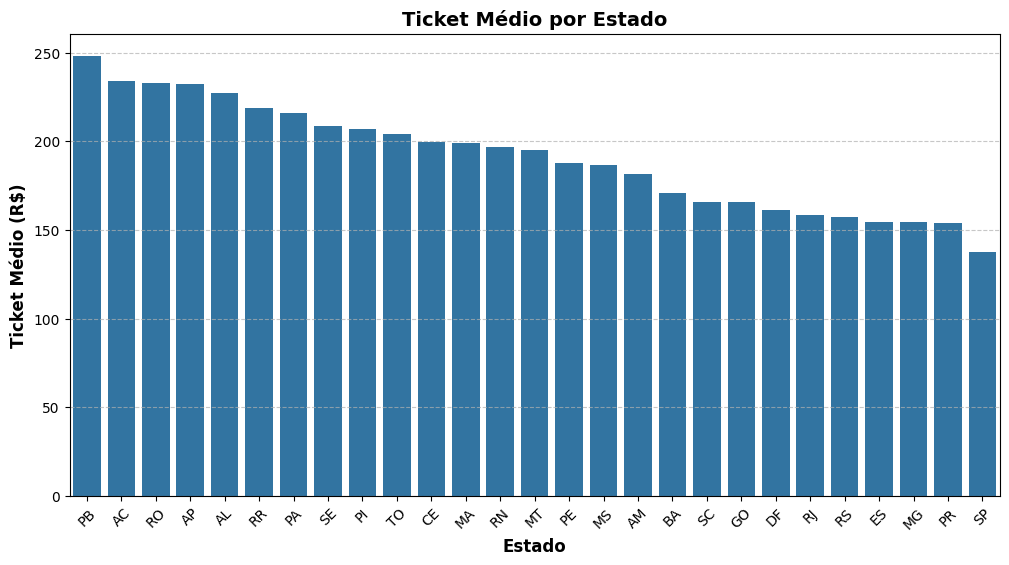

In [ ]:
df_merged = df_pedidos.merge(df_pagamentos, on='order_id')
df_merged = df_merged.merge(df_clientes[['customer_id', 'customer_state']], on='customer_id')
ticket_medio_por_estado = df_merged.groupby('customer_state')['payment_value'].mean().reset_index()
ticket_medio_por_estado = ticket_medio_por_estado.sort_values(by='payment_value', ascending=False)

#imagem
plt.figure(figsize=(12, 6))
sns.barplot(data=ticket_medio_por_estado, x='customer_state', y='payment_value', color='#1f77b4')
plt.xlabel('Estado', fontsize=12, fontweight='bold')
plt.ylabel('Ticket Médio (R$)', fontsize=12, fontweight='bold')
plt.title('Ticket Médio por Estado', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Há correlação entre o número de fotos de um produto e sua frequência de venda?

In [ ]:
frequencia_venda = df_itens_pedidos['product_id'].value_counts().reset_index()
frequencia_venda.columns = ['product_id', 'qtd_vendida']

produto_info = df_produtos[['product_id', 'product_photos_qty']]

dados = pd.merge(frequencia_venda, produto_info, on='product_id', how='inner')

correlacao = dados['qtd_vendida'].corr(dados['product_photos_qty'])

if correlacao >= 0.60:
    print(f"Correlação forte: {correlacao:.2f}")
elif correlacao >= 0.30:
    print(f"Correlação moderada: {correlacao:.2f}")
else:
    print(f"Correlação fraca ou inexistente: {correlacao:.2f}")



Correlação fraca ou inexistente: 0.00
